# NLP Sentiment Analysis: Apple and Google Products' Tweets

## 1 Introduction

This notebook presents a complete workflow for building and evaluating machine learning models to classify the sentiment of tweets related to Apple and Google products. The process includes data loading, cleaning, preprocessing, feature engineering, model training, and performance evaluation. The objective is to accurately determine whether a tweet expresses a positive, negative, or neutral sentiment towards these technology brands, and to recommend the most effective model for deployment.

## 2 Data Preparation

### 2.1 Data Loading

In [1]:
# Import necessary libraries
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk import pos_tag  
import string  
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline  
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer  
import re  

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

- Load the `tweet_product_company.csv` dataset

In [2]:
# Load the dataset from CSV file
df = pd.read_csv('/home/trigger/Documents/Flatiron/phase4/project/NLP-models-for-twitter-sentiment-analysis--google-and-apple-products-/data/tweet_product_company.csv', encoding='Latin-1')  # Read CSV file with correct encoding

- Inspect fist five columns

In [3]:
# Print first 5 rows
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


- Inspect columns 

In [4]:
# Print column attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


### 2.2 Data Cleaning

- Check duplicates

In [5]:
df.duplicated().sum()

np.int64(22)

- Drop duplicates

In [6]:
df = df.drop_duplicates()

In [7]:
# Confirm no duplicate entries
df.duplicated().sum()

np.int64(0)

- Rename Columns for Clarity

In [8]:
# Rename columns 
df = df.rename(columns={
    'tweet_text': 'tweet',  # Rename tweet text column
    'emotion_in_tweet_is_directed_at': 'product',  # Rename product column
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'  # Rename sentiment column
})

In [9]:
# Recheck columns' attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9071 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9070 non-null   object
 1   product    3282 non-null   object
 2   sentiment  9071 non-null   object
dtypes: object(3)
memory usage: 283.5+ KB


- It is evident the `products` column has many missing values.
- Inspect unique values for the `products` column

In [10]:
df['product'].value_counts()

product
iPad                               945
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: count, dtype: int64

Define a function **_categorize_product_** that takes the parameter `tweet` from **_df_**.
- Check if the input `tweet` is null or missing (If **_true_**; return **unknown**).
- If **_false_**; convert the string for each entry for the column `tweet` to lowercase to ensure case-insensitive matching.
- If the string for the column `tweet` contains the words: **_'iphone', 'ipad', or 'apple'_**; return **Apple**.
- If the string for the column `tweet` contains the words: **_'google', or 'android'_**; return **Google**.
- If none of these conditions are met return **unknown**.

In [11]:
# Define a function to categorize products
def categorize_product(tweet):
    if pd.isnull(tweet):
        return 'unknown'
    tweet = tweet.lower()
    if 'iphone' in tweet or 'ipad' in tweet or 'apple' in tweet:
        return 'Apple'
    elif 'google' in tweet or 'android' in tweet:
        return 'Google'
    else:
        return 'unknown'

# Apply the function to the 'tweet' column and fill the 'product' column
df['product'] = df['tweet'].apply(categorize_product)

# Verify the changes
df['product'].value_counts()


product
Apple      5520
Google     2766
unknown     785
Name: count, dtype: int64

- Handle Missing Values

In [12]:
# Srop entries with the value `unknown' for the `product` column
df = df[df['product'] != 'unknown']

In [13]:
# Drop rows with missing values in 'tweet' or 'sentiment' columns
df = df.dropna(subset=['tweet', 'sentiment']) 

In [14]:
# Remove rows where sentiment is 'I can't tell'
df = df[df['sentiment'] != "I can't tell"] 

In [15]:
# Reset index after dropping rows
df = df.reset_index(drop=True)  

In [16]:
# Re-inspect column attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8136 non-null   object
 1   product    8136 non-null   object
 2   sentiment  8136 non-null   object
dtypes: object(3)
memory usage: 190.8+ KB


In [17]:
# Rename Sentiments
df.loc[:, 'sentiment'] = df['sentiment'].replace({
    'No emotion toward brand or product': 'Neutral',
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative'})

In [18]:
# Verify changes
df['sentiment'].value_counts()

sentiment
Neutral     4636
Positive    2932
Negative     568
Name: count, dtype: int64

## 3 Data Preprocessing  

### 3.1 Define helper functions for preprocessing

- Text cleaning

In [19]:
# Define function to remove URLs, mentions, hashtags, punctuation, and lowercase
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

- Stopword removal

In [20]:
# Define function to remove stopwords from text
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    pronouns = {'i', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself',
                'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                'it', 'its', 'itself', 'we', 'us', 'our', 'ours', 'ourselves',
                'they', 'them', 'their', 'theirs', 'themselves'}
    stop_words += pronouns
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

- Lemmatization

In [21]:
# Define function to lemmatize each word in the text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

- Stemming

In [22]:
# Define function to Stem each word in the text
def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in tokens])

- POS Tagging

In [23]:
# Define function to lemmatize using POS tagging
def pos_lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return 'a'
        elif tag.startswith('V'):
            return 'v'
        elif tag.startswith('N'):
            return 'n'
        elif tag.startswith('R'):
            return 'r'
        else:
            return 'n'
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])

In [24]:
# Define function to stem using POS tagging
def pos_stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return ' '.join([stemmer.stem(word) for word, _ in pos_tags])

- Tokenization

In [25]:
# Define function to tokenize using TweetTokenizer
def tweet_tokenize_text(text):
    tokenizer = TweetTokenizer()
    return ' '.join(tokenizer.tokenize(text))

In [26]:
# Define function to tokenize using word_tokenize
def word_tokenize_text(text):
    return word_tokenize(text)

### 3.2 Extrapolatory Data Analysis

In [140]:
# create a copy of df
df_clean = df.copy()

In [141]:
df_clean['clean_tweet'] = df_clean['tweet'].apply(clean_text)
df_clean.head()

,tweet,product,sentiment,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a g iphone after hrs tweeting at it ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for also they should sale them...
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...


In [142]:
df_clean['stopwords_removed'] = df_clean['clean_tweet'].apply(remove_stopwords)
df_clean.head()

,tweet,product,sentiment,clean_tweet,stopwords_removed
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a g iphone after hrs tweeting at it ...,g iphone hrs tweeting dead need upgrade plugin...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for also they should sale them...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...,hope years festival isnt crashy years iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...,great stuff fri marissa mayer google tim oreil...


In [143]:
df_clean['tokenized_tweet'] = df_clean['stopwords_removed'].apply(word_tokenize_text)
df_clean.head()

,tweet,product,sentiment,clean_tweet,stopwords_removed,tokenized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a g iphone after hrs tweeting at it ...,g iphone hrs tweeting dead need upgrade plugin...,"[g, iphone, hrs, tweeting, dead, need, upgrade..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for also they should sale them...,wait also sale,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...,hope years festival isnt crashy years iphone app,"[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...,great stuff fri marissa mayer google tim oreil...,"[great, stuff, fri, marissa, mayer, google, ti..."


In [144]:
df_clean[['product', 'sentiment', 'tokenized_tweet']].head()

,product,sentiment,tokenized_tweet
0,Apple,Negative,"[g, iphone, hrs, tweeting, dead, need, upgrade..."
1,Apple,Positive,"[know, awesome, ipadiphone, app, youll, likely..."
2,Apple,Positive,"[wait, also, sale]"
3,Apple,Negative,"[hope, years, festival, isnt, crashy, years, i..."
4,Google,Positive,"[great, stuff, fri, marissa, mayer, google, ti..."


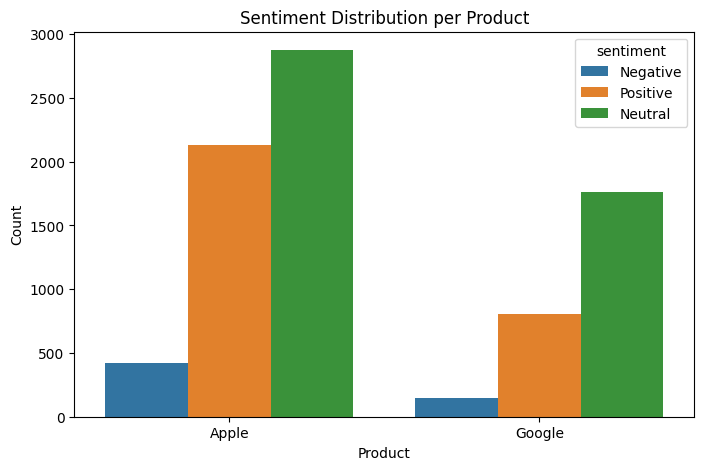

In [145]:
# Count plot of product vs sentiment
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='product', hue='sentiment')
plt.title('Sentiment Distribution per Product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.show()

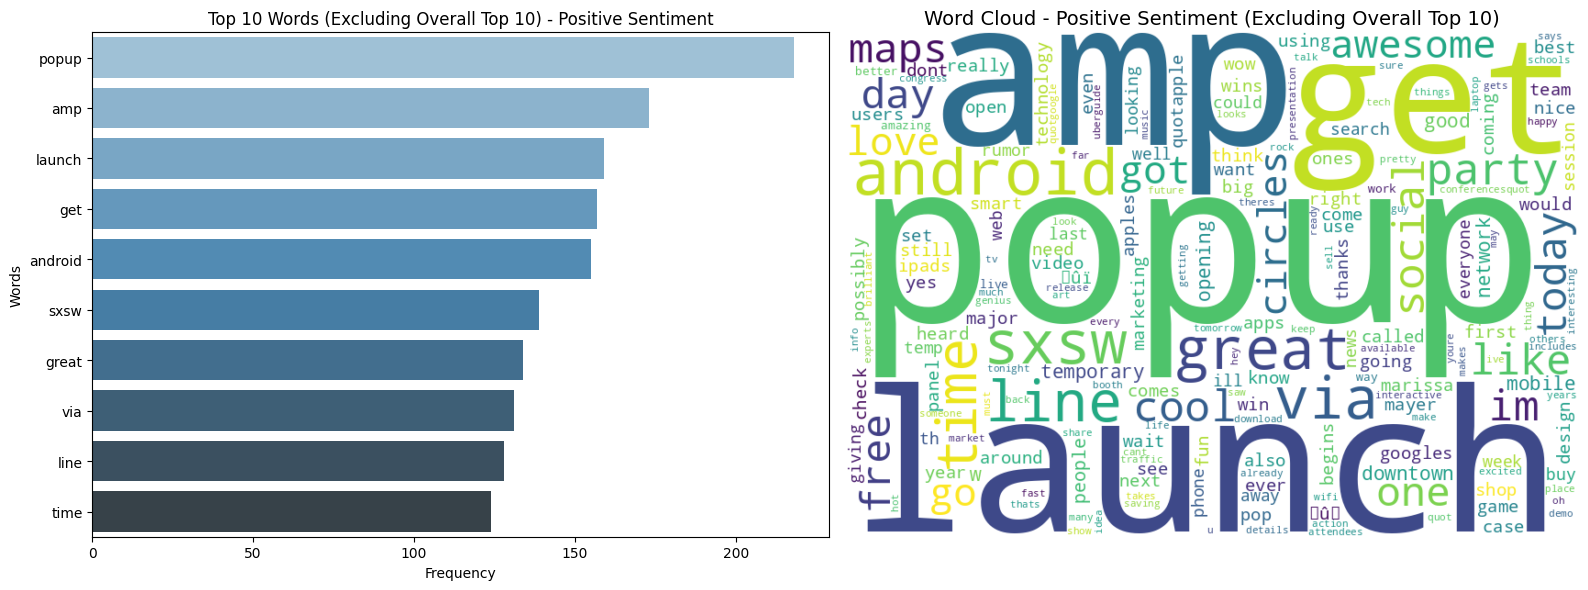

In [146]:
# Filter tokens for positive sentiment
positive_tokens = df_clean[df_clean['sentiment'] == 'Positive']['tokenized_tweet'].sum()
positive_freq = Counter(positive_tokens)
top_words = positive_freq.most_common(10)
words, counts = zip(*top_words)

# Determine top 10 words to exclude
top_10_words_to_exclude = positive_freq.most_common(10)
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words 
filtered_positive_freq = Counter()
for word, count in positive_freq.items():
    if word not in top_10_word_set:
        filtered_positive_freq[word] = count

top_words_for_barplot = filtered_positive_freq.most_common(10)
words_barplot, counts_barplot = zip(*top_words_for_barplot)

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot on LHS (uses filtered data)
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Blues_d', legend=False)
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Positive Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud on RHS (uses filtered data)
if filtered_positive_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=550, background_color='white').generate_from_frequencies(filtered_positive_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Positive Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

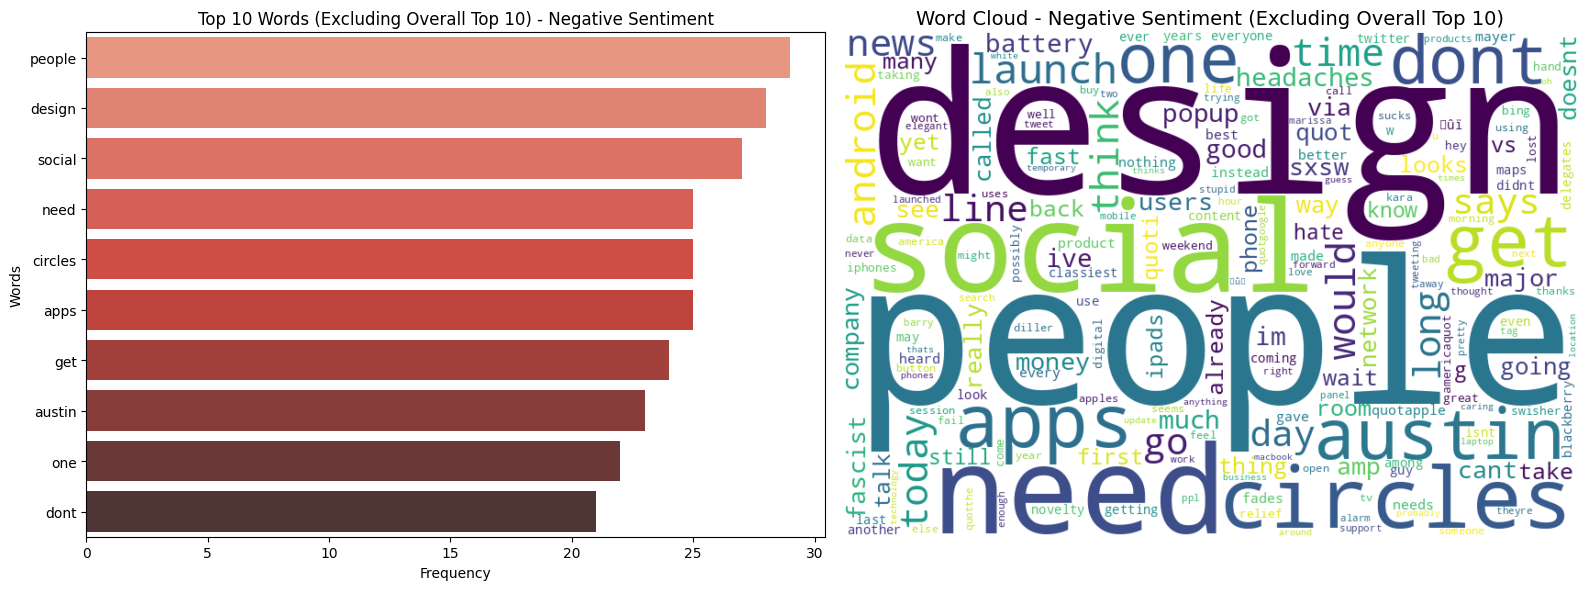

In [147]:
# Determine top 10 words to exclude
negative_tokens = df_clean[df_clean['sentiment'] == 'Negative']['tokenized_tweet'].sum()
negative_freq = Counter(negative_tokens) # This is the full frequency for all negative tokens

# Plot most common words excluding top ten most frequent
top_10_words_to_exclude = negative_freq.most_common(10) # Get top 10 from overall negative_freq
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words
filtered_negative_freq = Counter()
for word, count in negative_freq.items():
    if word not in top_10_word_set:
        filtered_negative_freq[word] = count

top_words_for_barplot = filtered_negative_freq.most_common(10) # Get top 10 from the filtered list
# Check if top_words_for_barplot is not empty before unpacking
if top_words_for_barplot:
    words_barplot, counts_barplot = zip(*top_words_for_barplot)
else:
    words_barplot, counts_barplot = [], [] # Assign empty lists if no words

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Reds_d', legend=False)
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Negative Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud plot
if filtered_negative_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=550, background_color='white').generate_from_frequencies(filtered_negative_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Negative Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

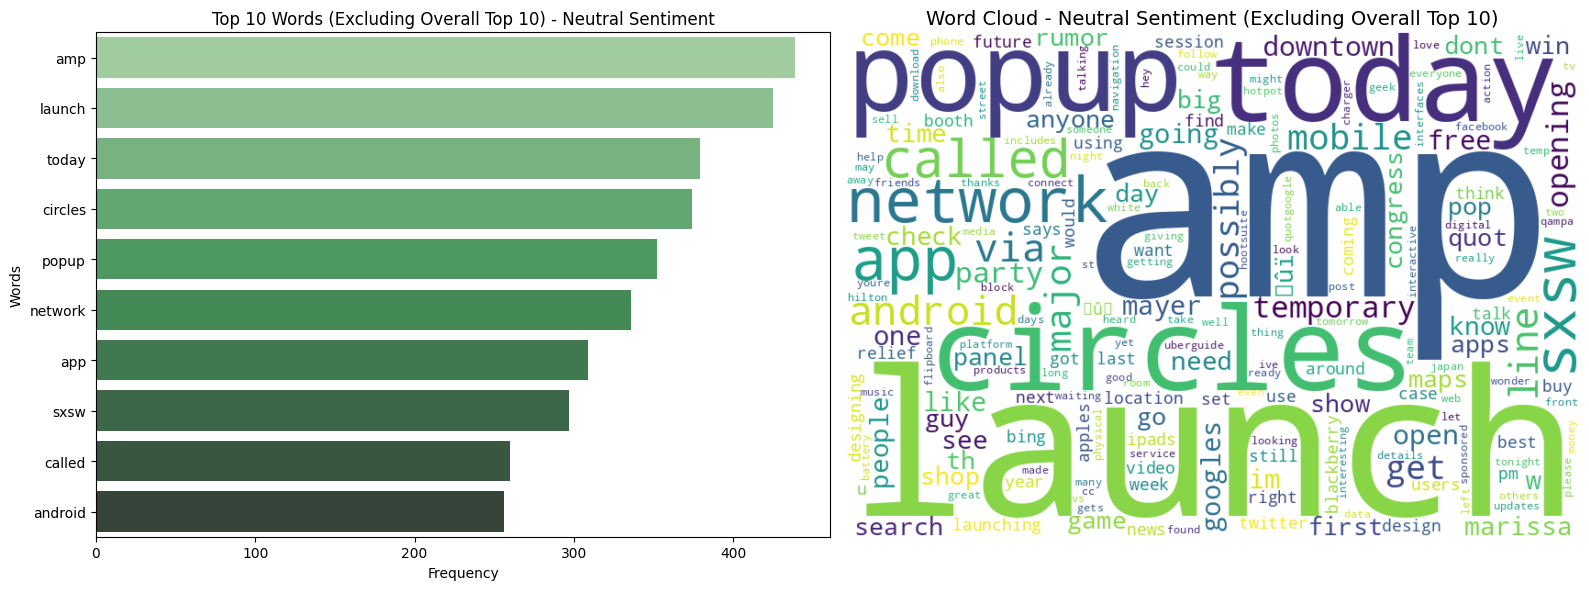

In [148]:
# Determine top 10 words to exclude
neutral_tokens = df_clean[df_clean['sentiment'] == 'Neutral']['tokenized_tweet'].sum()
neutral_freq = Counter(neutral_tokens) # This is the full frequency for all neutral tokens

# Plot most common words excluding top ten most frequent
top_10_words_to_exclude = neutral_freq.most_common(10) # Get top 10 from overall neutral_freq
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words
filtered_neutral_freq = Counter()
for word, count in neutral_freq.items():
    if word not in top_10_word_set:
        filtered_neutral_freq[word] = count

top_words_for_barplot = filtered_neutral_freq.most_common(10) # Get top 10 from the filtered list
# Check if top_words_for_barplot is not empty before unpacking
if top_words_for_barplot:
    words_barplot, counts_barplot = zip(*top_words_for_barplot)
else:
    words_barplot, counts_barplot = [], [] # Assign empty lists if no words

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Greens_d', legend=False)
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Neutral Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud plot
if filtered_neutral_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=550, background_color='white').generate_from_frequencies(filtered_neutral_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Neutral Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4 Modelling

### 4.1 Define Helper Functions for Vectorization

- Define function to perform **_Bag-of-Words_** vectorization

In [149]:
# Define function to perform BoW vectorization
def bow_vectorize_text(text_data, max_features=100, ngram_range=(1, 1)):
    bowvectorizer = CountVectorizer(max_features=max_features, stopwords=stop_words)
    bow_matrix = bowvectorizer.fit_transform(text_data)
    return bow_matrix, bowvectorizer

- Define funtion to perform **_Term Frequency-Inverse Document Frequency_** vectorization

In [150]:
# Define function to perform TF-IDF vectorization
def tfidf_vectorize_text(text_data, max_features=100, ngram_range=(1, 1)):
    tfdifvectorizer = TfidfVectorizer(max_features=max_features, stopwords=stop_words)
    tfidf_matrix = tfdifvectorizer.fit_transform(text_data)
    return tfidf_matrix, tdifvectorizer

### 4.2 Train-Validation-Test Split

In [169]:
# Prepare features and labels for modeling
X = df['tweet']  # Features: tweet text
y = df['sentiment']  # Labels: sentiment category

In [170]:
# Stratified split for balanced classes (stratify=y)
'''First split: Training_full (80% of X) and Test (20% of X)'''
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y) 

In [171]:
# Stratified split for balanced classes (stratify=y_train_full)
'''Second split: Training (80% of X_train_full) and Validation (20% of X_train_full)'''
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full)  

In [172]:
# Print the sizes of each set
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 5206
Validation set size: 1302
Test set size: 1628


### 4.3 Multinomial Naves Bayes Classifier

- The Multinomial Naves Bayes classifier is the baseline model.
- Define pipelines for the untuned Multimodal Naves Bayes Classifier to determine the best performing alternative.
- The best performing alternative is selected for Hyper-parameter tuning using GridSearchCV, 

In [42]:
mnb_lemma_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', CountVectorizer()),  # BoW vectorization
        ('model', MultinomialNB()) 
    ])

In [43]:
mnb_lemma_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', TfidfVectorizer()),  # TF-IDF vectorization
        ('model', MultinomialNB()) 
    ])

In [44]:
mnb_stem_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', CountVectorizer()),# BoW vectorization
        ('model', MultinomialNB())  
    ])

In [45]:
mnb_stem_tfdif = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', TfidfVectorizer()),# TF-IDF vectorization
        ('model', MultinomialNB())  
    ])

In [46]:
mnb_lemma_bow.fit(X_train, y_train)
val_score_mnb_lemma_bow = mnb_lemma_bow.score(X_val, y_val)
val_score_mnb_lemma_bow

0.642089093701997

In [47]:
mnb_lemma_tfidf.fit(X_train, y_train)
val_score_mnb_lemma_tfdif = mnb_lemma_tfidf.score(X_val, y_val)
val_score_mnb_lemma_tfdif 

0.6459293394777266

In [48]:
mnb_stem_bow.fit(X_train, y_train)
val_score_mnb_stem_bow = mnb_stem_bow.score(X_val, y_val)
val_score_mnb_stem_bow 

0.6551459293394777

In [49]:
mnb_stem_tfdif.fit(X_train, y_train)
val_score_mnb_stem_tfdif = mnb_stem_tfdif.score(X_val, y_val)
val_score_mnb_stem_tfdif 

0.6466973886328725

- The vanilla **Multinomial Naves Bayes Classifier** fitted with **_Stemmed_** data that is vectorized via the **_Bag-of-Words_** technique (**mnb_stem_bow**) is the better performing alternative.
- This model is selected for Hyper-parameter tuning.

In [50]:
# Hyperparameter tuning for mnb_stem_bow using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define named functions for FunctionTransformer (must be top-level for pickling)
def clean_texts(texts):
    return [clean_text(t) for t in texts]
def remove_stopwords_texts(texts):
    return [remove_stopwords(t) for t in texts]
def stem_texts(texts):
    return [stem_text(t) for t in texts]

# Define the pipeline (same as mnb_stem_bow, but with named functions)
mnb_stem_bow_pipeline = Pipeline([
    ('clean', FunctionTransformer(clean_texts, validate=False)),
    ('stopwords', FunctionTransformer(remove_stopwords_texts, validate=False)),
    ('stem', FunctionTransformer(stem_texts, validate=False)),
    ('vectorize', CountVectorizer()),
    ('model', MultinomialNB())
])

# Define parameter grid for alpha
param_grid = {
    'model__alpha': [0.1, 0.5, 1.0, 1.2, 1.5, 2.0]
}

grid_search = GridSearchCV(mnb_stem_bow_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)


Best alpha: {'model__alpha': 2.0}
Best cross-validated accuracy: 0.6421416731660277


In [51]:
val_score_grid_search_mnb = grid_search.score(X_val, y_val)
val_score_grid_search_mnb

0.6490015360983102

- The hyperparameter tuning of the Multinomial Naive Bayes (MNB) model did not yield an improvement in validation accuracy because the baseline model was already well-calibrated for the dataset, and the available hyperparameters (such as `alpha`) may not significantly impact performance given the nature of the text data and feature representation. Additionally, MNB makes strong independence assumptions between features, which may limit its ability to capture complex relationships in the data.

- Building a K Nearest Neighbour (KNN) classifier is necessary as it provides a fundamentally different approach to classification. Unlike MNB, which relies on probabilistic assumptions, KNN is a non-parametric, instance-based learning algorithm that classifies samples based on the majority label among their nearest neighbors in the feature space. This allows KNN to potentially capture more nuanced patterns and relationships in the data that MNB might miss.

- KNN can result in a better performing model because it does not assume feature independence and can adapt to the local structure of the data. By considering the similarity between tweets in the transformed feature space (e.g., after TF-IDF vectorization), KNN can leverage contextual and semantic similarities, which may lead to improved classification accuracy, especially if the sentiment classes are not linearly separable or if there are complex interactions between features.

### 4.4 K Nearest Neighbour Classifier

- Define pipelines for the untuned K Nearest Neighbour Classifier to determine the best performing alternative.
- The best performing alternative will be selected for Hyper-parameter tuning using GridSearchCV, 

In [52]:
knn_lemma_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', CountVectorizer()),  # BoW vectorization
        ('model', KNeighborsClassifier()) 
    ])

In [53]:
knn_lemma_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', TfidfVectorizer()),  # TF-IDF vectorization
        ('model', KNeighborsClassifier()) 
    ])

In [54]:
knn_stem_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', CountVectorizer()),# BoW vectorization
        ('model', KNeighborsClassifier())  
    ])

In [55]:
knn_stem_tfdif = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', TfidfVectorizer()),# TF-IDF vectorization
        ('model', KNeighborsClassifier())  
])

In [56]:
knn_lemma_bow.fit(X_train, y_train)
val_score_knn_lemma_bow = knn_lemma_bow.score(X_val, y_val)
val_score_knn_lemma_bow

0.6021505376344086

In [57]:
knn_lemma_tfidf.fit(X_train, y_train)
val_score_knn_lemma_tfdif = knn_lemma_tfidf.score(X_val, y_val)
val_score_knn_lemma_tfdif

0.619815668202765

In [58]:
knn_stem_bow.fit(X_train, y_train)
val_score_knn_stem_bow = knn_stem_bow.score(X_val, y_val)
val_score_knn_stem_bow 

0.5929339477726574

In [59]:
knn_stem_tfdif.fit(X_train, y_train)
val_score_knn_stem_tfdif = knn_stem_tfdif.score(X_val, y_val)
val_score_knn_stem_tfdif

0.6175115207373272

- The vanilla **K Nearest Neighbour Classifier** fitted with **_Lematized_** data that is vectorized via the **_TF-IDF_** technique (**knn_lemma_tfidf**) is the better performing alternative.
- This model is selected for Hyper-parameter tuning.

In [60]:
# Hyperparameter tuning for knn_lemma_tfidf using GridSearchCV
from sklearn.model_selection import GridSearchCV

def clean_texts(texts):
    return [clean_text(t) for t in texts]
def remove_stopwords_texts(texts):
    return [remove_stopwords(t) for t in texts]
def lemmatize_texts(texts):
    return [lemmatize_text(t) for t in texts]

knn_lemma_tfidf_pipeline = Pipeline([
    ('clean', FunctionTransformer(clean_texts, validate=False)),
    ('stopwords', FunctionTransformer(remove_stopwords_texts, validate=False)),
    ('lemmatize', FunctionTransformer(lemmatize_texts, validate=False)),
    ('vectorize', TfidfVectorizer()),
    ('model', KNeighborsClassifier())
])

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 14, 17, 21],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

grid_search_knn = GridSearchCV(knn_lemma_tfidf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid_search_knn.fit(X_train, y_train)

print("Best parameters:", grid_search_knn.best_params_)
print("Best cross-validated accuracy:", grid_search_knn.best_score_)


Best parameters: {'model__n_neighbors': 11, 'model__p': 2, 'model__weights': 'distance'}
Best cross-validated accuracy: 0.6252424123415954


In [61]:
val_score_grid_search_knn = grid_search_knn.score(X_val, y_val)
val_score_grid_search_knn

0.6597542242703534

- The improvement in validation accuracy from the untuned KNN model (0.61982) to the hyper-parameter tuned KNN model (0.65975) is due to the optimization of key model parameters such as the number of neighbors (`n_neighbors`), the weighting scheme (`weights`), and the distance metric (`p`). 
- Hyper-parameter tuning allows the model to better capture the underlying structure of the data, leading to more accurate classification by selecting the most appropriate configuration for the dataset.
- Building an ensemble model like the Random Forest Classifier is necessary because it combines the predictions of multiple decision trees, reducing the risk of overfitting and improving generalization. 
- Random Forests can capture complex, non-linear relationships in the data and are robust to noise and outliers. 
- Unlike the Multinomial Naive Bayes classifier, which assumes feature independence, and KNN, which can be sensitive to irrelevant features and data scaling, Random Forests can automatically handle feature interactions and provide feature importance scores. 
- Thus, ensemble models are well-suited for high-dimensional, noisy text data and typically perform single-model approaches such as KNN and MNB Classifiers.

### 4.5 Random Forest Classifier

In [62]:
rf_lemma_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', CountVectorizer()),  # BoW vectorization
        ('model', RandomForestClassifier(random_state=42)) 
    ])

In [63]:
rf_lemma_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', TfidfVectorizer()),  # TF-IDF vectorization
        ('model', RandomForestClassifier(random_state=42)) 
    ])

In [64]:
rf_stem_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', CountVectorizer()),# BoW vectorization
        ('model', RandomForestClassifier(random_state=42))  
    ])

In [65]:
rf_stem_tfdif = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', TfidfVectorizer()),# TF-IDF vectorization
        ('model', RandomForestClassifier(random_state=42))  
])

In [66]:
rf_lemma_bow.fit(X_train, y_train)
val_score_rf_lemma_bow = rf_lemma_bow.score(X_val, y_val)
val_score_rf_lemma_bow

0.6697388632872504

In [67]:
rf_lemma_tfidf.fit(X_train, y_train)
val_score_rf_lemma_tfdif = rf_lemma_tfidf.score(X_val, y_val)
val_score_rf_lemma_tfdif

0.6682027649769585

In [68]:
rf_stem_bow.fit(X_train, y_train)
val_score_rf_stem_bow = rf_stem_bow.score(X_val, y_val)
val_score_rf_stem_bow 

0.6620583717357911

In [69]:
rf_stem_tfdif.fit(X_train, y_train)
val_score_rf_stem_tfdif = rf_stem_tfdif.score(X_val, y_val)
val_score_rf_stem_tfdif

0.6597542242703534

- The vanilla **Random Forest Classifier** fitted with **_Lematized_** data that is vectorized via the **_BOW_** technique (**rf_lemma_bow**) is the better performing alternative.
- This model is selected for Hyper-parameter tuning.

In [70]:
# Hyperparameter tuning for rf_lemma_bow using GridSearchCV
from sklearn.model_selection import GridSearchCV

def clean_texts(texts):
    return [clean_text(t) for t in texts]
def remove_stopwords_texts(texts):
    return [remove_stopwords(t) for t in texts]
def lemmatize_texts(texts):
    return [lemmatize_text(t) for t in texts]

rf_lemma_bow_pipeline = Pipeline([
    ('clean', FunctionTransformer(clean_texts, validate=False)),
    ('stopwords', FunctionTransformer(remove_stopwords_texts, validate=False)),
    ('lemmatize', FunctionTransformer(lemmatize_texts, validate=False)),
    ('vectorize', CountVectorizer()),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(rf_lemma_bow_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validated accuracy:", grid_search_rf.best_score_)


Best parameters: {'model__bootstrap': False, 'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best cross-validated accuracy: 0.6500188138842039


In [71]:
val_score_grid_search_rf = grid_search_rf.score(X_val, y_val)
val_score_grid_search_rf

0.684331797235023

The tuned Random Forest Classifier achieved an accuracy of 0.6843, improving upon the untuned model's accuracy of 0.6697. 
- This improvement is primarily due to the optimization of key hyperparameters such as the number of trees (`n_estimators`), tree depth (`max_depth`), and minimum samples required for splits and leaves. 
- By systematically searching for the best combination of these parameters, the model is better able to capture relevant patterns in the data and avoid both underfitting and overfitting, leading to enhanced predictive performance.

Despite these gains, Random Forest Classifiers have inherent limitations. 
- They can become computationally expensive with large datasets or a high number of trees, and their predictions may lack interpretability due to the ensemble nature of the model. 
- Additionally, Random Forests may struggle to capture complex, high-level abstractions or sequential dependencies in text data, as they rely on bag-of-words or similar feature representations that ignore word order and context.

Building a neural network model, such as a deep learning architecture, offers the potential for further improvement. 
- Neural networks, especially those designed for natural language processing (e.g., recurrent neural networks, convolutional neural networks, or transformers), can learn hierarchical and contextual representations of text. 
- This allows them to capture subtle semantic relationships and dependencies that traditional models like Random Forests cannot, potentially leading to higher accuracy and better generalization on complex sentiment classification tasks.

### 4.6 Neural Network

- Implementing a simple feedforward neural network (Multi-Layer Perceptron) for sentiment classification using Keras. 
- The pipeline encapsulates text cleaning, stopwords removal, lemmatization, TF-IDF vectorization, and a sequential neural network model. 
- The pipeline justifies conformity to the preprocessing workflow and guarantees consistency.TfidfVectorizer

In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Preprocess data: clean, remove stopwords, lemmatize, TF-IDF vectorize
def preprocess_texts(texts):
    return [lemmatize_text(remove_stopwords(clean_text(t))) for t in texts]

X_train_nn = preprocess_texts(X_train)
X_val_nn = preprocess_texts(X_val)
X_test_nn = preprocess_texts(X_test)

# TF-IDF vectorization
tfidf_vectorizer_nn = TfidfVectorizer(max_features=1000)
X_train_vec = tfidf_vectorizer_nn.fit_transform(X_train_nn).toarray()
X_val_vec = tfidf_vectorizer_nn.transform(X_val_nn).toarray()
X_test_vec = tfidf_vectorizer_nn.transform(X_test_nn).toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
y_val_enc = to_categorical(label_encoder.transform(y_val))
y_test_enc = to_categorical(label_encoder.transform(y_test))

In [73]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vec.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(y_train_enc.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2025-07-11 10:12:30.366559: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [74]:
# Train the model
history = model.fit(
    X_train_vec, y_train_enc,
    validation_data=(X_val_vec, y_val_enc),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val_vec, y_val_enc, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5270 - loss: 0.9577 - val_accuracy: 0.6060 - val_loss: 0.8161
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6373 - loss: 0.7698 - val_accuracy: 0.6421 - val_loss: 0.7582
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7257 - loss: 0.6430 - val_accuracy: 0.6413 - val_loss: 0.7629
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7907 - loss: 0.5260 - val_accuracy: 0.6321 - val_loss: 0.7966
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8238 - loss: 0.4506 - val_accuracy: 0.6390 - val_loss: 0.8533
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8564 - loss: 0.3745 - val_accuracy: 0.6444 - val_loss: 0.9476
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8681 - loss: 0.3338 - val_accuracy: 0.6329 - val_loss: 1.0324
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8939 - loss: 0.2759 - val_accuracy: 0.

In [75]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,691 (1.59 MB)

 Trainable params: 138,563 (541.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 277,128 (1.06 MB)

After trying multiple configurations of the hidden **_Dense Layers_**, the neural network model (Multi-Layer Perceptron) plateaued at a validation accuracy of 0.6429. Possible limitations of the neural network model could be attributed to:

- **Feature Representation**: The model relies on vectorized text features, which could be limiting the neural network in capturing word order or contextual relationships, potentially limiting its ability to understand nuanced sentiment.
- **Model Complexity**: The architecture is relatively simple, consisting of only a few dense layers. This may restrict its capacity to model complex patterns in the data.
- **Overfitting/Underfitting**: Without careful tuning, the model may overfit (memorize training data) or underfit (fail to learn enough), especially given the fixed dropout rates and layer sizes.
- **Hyperparameter Sensitivity**: Neural networks are highly sensitive to hyperparameters such as learning rate, batch size, number of layers, number of neurons, activation functions, and dropout rates.

The neural network model can be improved by leveraging pretrained NLP models such as **BERT**. However, transfer learning is beyond the scope of this project's objectives.  

## 5 Model Performance Comparison on Test Set

- The tuned models' performance is compared on the test set.
- The best performing model is pickled using joblib.



In [81]:
# Compute test set accuracy for each tuned model
test_score_nb = grid_search.score(X_test, y_test)
test_score_knn = grid_search_knn.score(X_test, y_test)
test_score_rf = grid_search_rf.score(X_test, y_test)
test_loss_nn, test_score_nn = model.evaluate(X_test_vec, y_test_enc, verbose=0)

# Format results in a DataFrame
results_df = pd.DataFrame({
    'Model': ['Tuned MultinomialNB', 'Tuned KNN', 'Tuned RandomForest', 'Neural Network'],
    'Test_Accuracy': [test_score_nb, test_score_knn, test_score_rf, test_score_nn]
})

# Compute precision, recall, and f1-score for each model
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict labels for each model
y_pred_nb = grid_search.predict(X_test)
y_pred_knn = grid_search_knn.predict(X_test)
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_nn = (model.predict(X_test_vec) > 0.5).astype(int)  # Prediction threshold for neural network

# Add precision, recall, and f1-score to the DataFrame
results_df['Test_Precision'] = [precision_score(y_test, y_pred_nb, average='weighted'),
                               precision_score(y_test, y_pred_knn, average='weighted'),
                               precision_score(y_test, y_pred_rf, average='weighted'),
                               precision_score(y_test_enc, y_pred_nn, average='weighted')]
results_df['Test_Recall'] = [recall_score(y_test, y_pred_nb, average='weighted'),
                            recall_score(y_test, y_pred_knn, average='weighted'),
                            recall_score(y_test, y_pred_rf, average='weighted'),
                            recall_score(y_test_enc, y_pred_nn, average='weighted')]
results_df['Test_F1'] = [f1_score(y_test, y_pred_nb, average='weighted'),
                        f1_score(y_test, y_pred_knn, average='weighted'),
                        f1_score(y_test, y_pred_rf, average='weighted'),
                        f1_score(y_test_enc, y_pred_nn, average='weighted')]
results_df

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Model,Test_Accuracy,Test_Precision,Test_Recall,Test_F1
0,Tuned MultinomialNB,0.662162,0.662835,0.662162,0.632738
1,Tuned KNN,0.640663,0.645205,0.640663,0.602254
2,Tuned RandomForest,0.671376,0.688206,0.671376,0.632423
3,Neural Network,0.662162,0.652279,0.656634,0.651120


- Visualize performance metrics

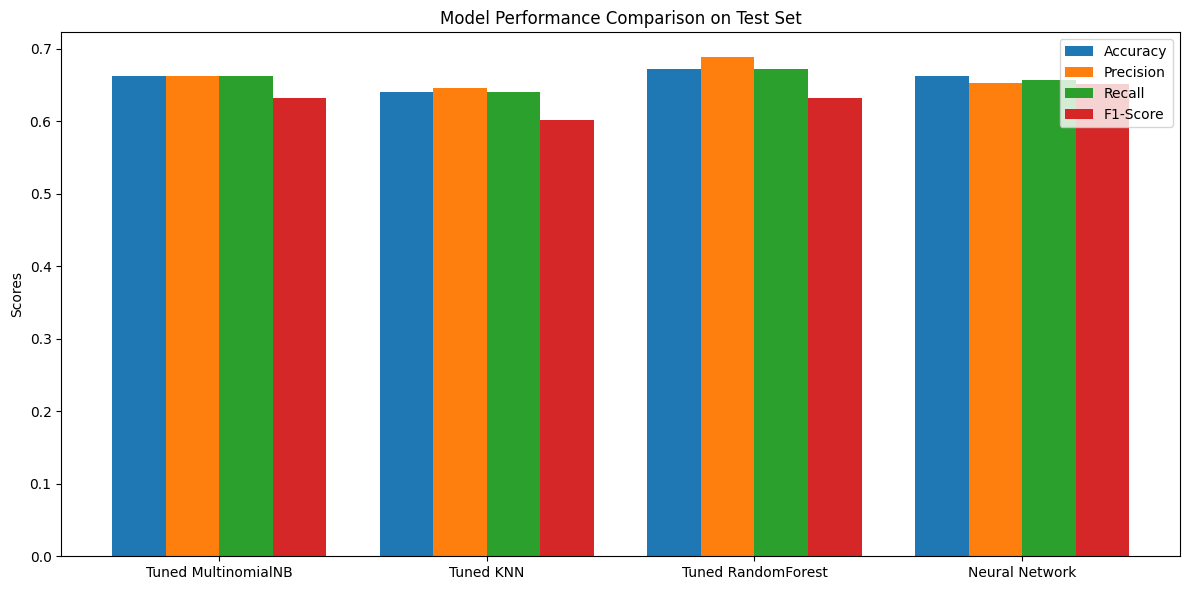

In [88]:
# Plotting the results
import matplotlib.pyplot as plt

models = results_df['Model']
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width*1.5, results_df['Test_Accuracy'], width, label='Accuracy')
rects2 = ax.bar(x - width/2, results_df['Test_Precision'], width, label='Precision')
rects3 = ax.bar(x + width/2, results_df['Test_Recall'], width, label='Recall')
rects4 = ax.bar(x + width*1.5, results_df['Test_F1'], width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison on Test Set')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.legend()

plt.tight_layout()
plt.show()

- plot confusion matrices

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


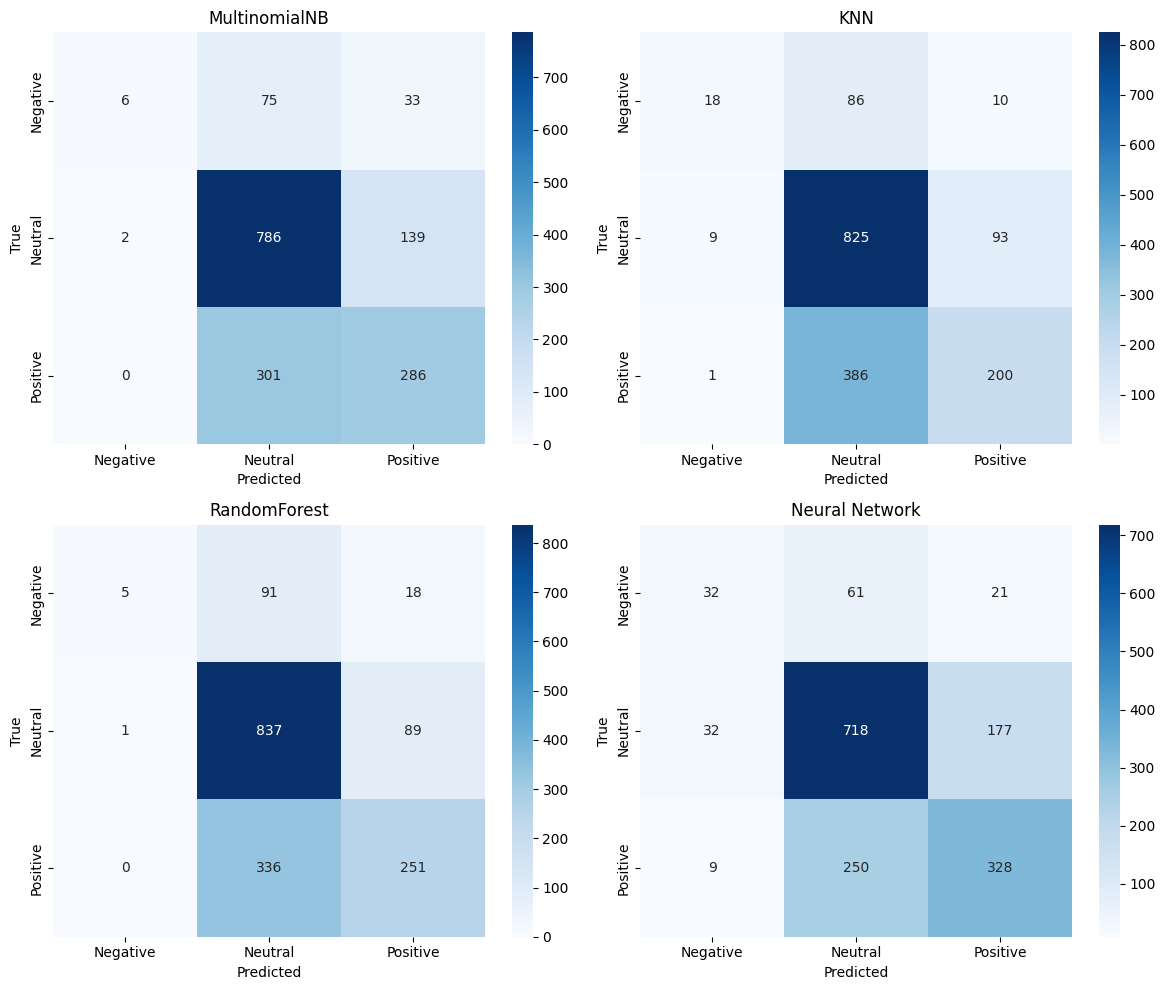

In [108]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()  
le.fit(y_train) 
label_names = le.classes_ 

# Get predictions for each model
y_pred_mnb = grid_search.predict(X_test)
y_pred_knn = grid_search_knn.predict(X_test)
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_nn = np.argmax(model.predict(X_test_vec), axis=1)  # Use argmax for multiclass

# Compute confusion matrices
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_nn = confusion_matrix(np.argmax(y_test_enc, axis=1), y_pred_nn)  # Both now in single-label format

# Set up the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot confusion matrix for MultinomialNB
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], xticklabels=label_names, yticklabels=label_names)
axes[0, 0].set_title('MultinomialNB')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')

# Plot confusion matrix for KNN
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1], xticklabels=label_names, yticklabels=label_names)
axes[0, 1].set_title('KNN')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

# Plot confusion matrix for RandomForest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], xticklabels=label_names, yticklabels=label_names)
axes[1, 0].set_title('RandomForest')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')

# Plot confusion matrix for Neural Network
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], xticklabels=label_names, yticklabels=label_names)
axes[1, 1].set_title('Neural Network')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# Insert vertical and horizontal spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.2) 

plt.tight_layout()
plt.show()

- The tuned Random Forest Classifier is the best model according to the test set accuracy reported in results_df. The model outperforms the tuned Multinomial Naive Bayes, KNN, and Neural Network models. 
- The Random Forest's superior performance can be attributed to its ensemble approach, which combines multiple decision trees to reduce overfitting and capture complex, non-linear relationships in the data. 
- Additionally, Random Forests are robust to noise and can handle high-dimensional feature spaces, making them well-suited for text classification tasks.

Hence, the tuned Random Forest Classifier is selected for deployment because it achieves the highest accuracy on unseen data, indicating strong generalization capability. It strikes and effective balance on predictive power, robustness, and interpretability makes the tuned Random Forest Classifier the optimal choice for deployment in this sentiment analysis pipeline. Furthermore, Random Forests provide feature importance scores, aiding interpretability, and are less sensitive to hyperparameter choices compared to neural networks. 


In [ ]:
import joblib

# Save the tuned Random Forest Classifier (best estimator from grid_search_rf)
joblib.dump(grid_search_rf.best_estimator_, 'tuned_random_forest_classifier.joblib')

## 6 Model Interpretabilty

- Since Random Forests are black box models, this section utilizes the LIME library to interpret the tuned_random_forest_classifier.

In [ ]:
import lime
import lime.lime_tabular

# Get the best estimator from the grid search
tuned_rf = grid_search_rf.best_estimator_

# Extract the vectorizer from the pipeline to get feature names
vectorizer = tuned_rf.named_steps['vectorize']
X_train_vec = vectorizer.transform(clean_texts(X_train))  # Vectorize training data
feature_names = vectorizer.get_feature_names_out()

# Initialize the LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_vec.toarray()),
    feature_names=feature_names,
    mode='classification'  # Use 'regression' for regression tasks
)

# Choose an instance to explain (e.g., the first validation sample)
instance = X_val[0]  # Original text
instance_vec = vectorizer.transform([clean_texts([instance])[0]]).toarray()[0]

# Get the explanation for the instance
exp = explainer.explain_instance(
    data_row=instance_vec,
    predict_fn=lambda x: tuned_rf.predict_proba(vectorizer.transform(clean_texts(x))),
    num_features=10  # Number of features to show in the explanation
)

# Visualize the explanation in notebook
exp.show_in_notebook()  

# Export to as a list
print(exp.as_list())

## 7 Conclusion

## 8 Next Steps

- Increase max features for vectorizers.
- Implement pipelines that leverage POS tagging to improve the models' contextual understanding on text data.
- Implement PCA for dimensionality reduction.
- Apply SMOTE to address class imbalance (RandomForestClassifier performs poorly on the minority class **_negative_**).
- Experiment with more sophisticated text representations such as TF-IDF n-grams, and word embedding frameworks such as Word2Vec.
- Implement transfer learning leveraging BERT pretrained models for the Multi-layer Perceptron Neural Network model.
